# Understanding Student Dropout Trends: An Exploratory Analysis

<img src="./drop_sc.png" alt="Image description" width="700">


## 1.Business Understanding


### This project delves into the multifaceted issue of student dropout rates, aiming to uncover the key factors that influence a student's decision to leave school prematurely. This analysis explores four dimensions including family factors, financial and economics, application support, and education engagement. Data is gathered from Kaggle (https://www.kaggle.com/datasets/naveenkumar20bps1137/predict-students-dropout-and-academic-success?select=dataset.csv)  and the goal is that the methodologies demonstrated here—ranging from exploratory data analysis and statistical testing to predictive modeling—showcase a reproducible framework for educational data mining. By providing insights into the complex interplay of factors affecting student retention, this project could serve as a valuable resource for educators, policymakers, and researchers aiming to develop targeted.


1. What Family Factors Contribute to Student Dropout Rates?
2. Do financial and economic factors reduce or increase Dropping Out?
3. Does application support Prevent Dropout?
4. How Does education engagement Relate to Student Dropout?

## 2.Data Understanding

In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc,
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

pd.set_option('display.max_columns', None)
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

In [341]:
marital_target_counts_df = df_filtered.groupby(['Marital_status','Target'])['Target'].count()

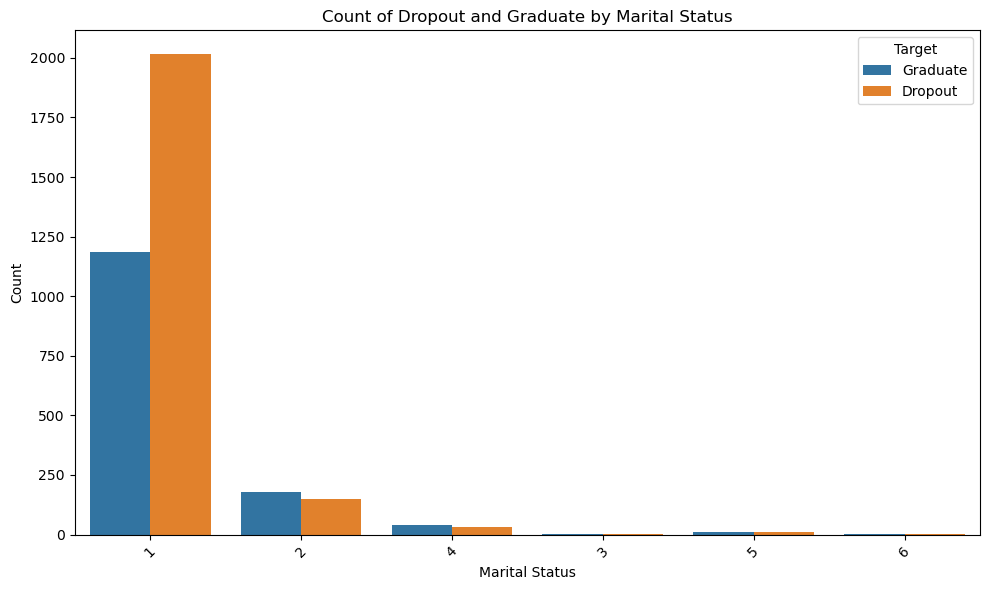

In [344]:
import seaborn as sns

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered, x='Marital_status', hue='Target')

plt.title('Count of Dropout and Graduate by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Target', labels=['Graduate', 'Dropout'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();


### Exploratory Data Analysis (EDA)

In [259]:
df = pd.read_csv('./dataset.csv')
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [330]:
# Drop rows where Target is 'Enrolled'
df_filtered = df[df['Target'] != 'Enrolled']


In [331]:
df_filtered.Target.value_counts(normalize=True)

Target
Graduate    0.60854
Dropout     0.39146
Name: proportion, dtype: float64

In [260]:
print("This dataset has {} rows and {} columns".format(df.shape[0],df.shape[1]))

This dataset has 4424 rows and 35 columns


In [261]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

### Standardizing column names with snake_notation 

In [262]:

df.columns = df.columns.str.replace(' ', '_')

In [263]:
df.columns.tolist()

['Marital_status',
 'Application_mode',
 'Application_order',
 'Course',
 'Daytime/evening_attendance',
 'Previous_qualification',
 'Nacionality',
 "Mother's_qualification",
 "Father's_qualification",
 "Mother's_occupation",
 "Father's_occupation",
 'Displaced',
 'Educational_special_needs',
 'Debtor',
 'Tuition_fees_up_to_date',
 'Gender',
 'Scholarship_holder',
 'Age_at_enrollment',
 'International',
 'Curricular_units_1st_sem_(credited)',
 'Curricular_units_1st_sem_(enrolled)',
 'Curricular_units_1st_sem_(evaluations)',
 'Curricular_units_1st_sem_(approved)',
 'Curricular_units_1st_sem_(grade)',
 'Curricular_units_1st_sem_(without_evaluations)',
 'Curricular_units_2nd_sem_(credited)',
 'Curricular_units_2nd_sem_(enrolled)',
 'Curricular_units_2nd_sem_(evaluations)',
 'Curricular_units_2nd_sem_(approved)',
 'Curricular_units_2nd_sem_(grade)',
 'Curricular_units_2nd_sem_(without_evaluations)',
 'Unemployment_rate',
 'Inflation_rate',
 'GDP',
 'Target']

### Looking for missing values

In [264]:
print("There are {} columns wiht missing data.".format(len((df.isnull().mean() * 100)[df.isnull().mean() * 100 > 0])))

There are 0 columns wiht missing data.


In [265]:
#(df.isnull().mean() * 100)[df.isnull().mean() * 100 > 0]


In [266]:
# missing_percentage = (df.isnull().mean() * 100)[df.isnull().mean() * 100 > 0].sort_values(ascending=False)
# missing_percentage.plot(kind='barh', color='blue')
# plt.title('Percentage of Missing Values by Column')
# plt.xlabel('Percentage (%)')
# plt.ylabel('Columns')
# plt.xticks(rotation=45)
# plt.grid(axis='x')
# plt.show()

In [267]:
df.dtypes

Marital_status                                      int64
Application_mode                                    int64
Application_order                                   int64
Course                                              int64
Daytime/evening_attendance                          int64
Previous_qualification                              int64
Nacionality                                         int64
Mother's_qualification                              int64
Father's_qualification                              int64
Mother's_occupation                                 int64
Father's_occupation                                 int64
Displaced                                           int64
Educational_special_needs                           int64
Debtor                                              int64
Tuition_fees_up_to_date                             int64
Gender                                              int64
Scholarship_holder                                  int64
Age_at_enrollm

### Isolating categorical features

In [268]:
df.select_dtypes(include='object').columns

Index(['Target'], dtype='object')

In [269]:
print("At a first glance, there are {} categorical features.".format(len(df.select_dtypes(include='object').columns)))

At a first glance, there are 1 categorical features.


### However, looking at the dataset schema provided some features like Marital Status, Application Mode, Course, Daytime/Evening Attendance,  Nationality, Mother's Qualification, Father's Qualification, Mother's Occupation, Father's Occupation, Displaced, Educational Special Needs, Debtor, Tuition Fees Up To Date, Gender, Scholarship Holder, International are categorical. Thus, these subset would need to be converteted to category.

In [270]:
cat_feat = ['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytime/evening_attendance', 'Previous_qualification', 'Nacionality', "Mother's_qualification", 
            "Father's_qualification", "Mother's_occupation", "Father's_occupation", 'Displaced', 'Educational_special_needs',
            'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'Age_at_enrollment', 'International']

In [271]:
df[cat_feat] = df[cat_feat].astype(str)

In [272]:
print("After a review, there are {} categorical features.".format(len(df.select_dtypes(include='object').columns)))

After a review, there are 20 categorical features.


### Isolating quantitative features

In [273]:
df.select_dtypes(exclude='object').columns

Index(['Curricular_units_1st_sem_(credited)',
       'Curricular_units_1st_sem_(enrolled)',
       'Curricular_units_1st_sem_(evaluations)',
       'Curricular_units_1st_sem_(approved)',
       'Curricular_units_1st_sem_(grade)',
       'Curricular_units_1st_sem_(without_evaluations)',
       'Curricular_units_2nd_sem_(credited)',
       'Curricular_units_2nd_sem_(enrolled)',
       'Curricular_units_2nd_sem_(evaluations)',
       'Curricular_units_2nd_sem_(approved)',
       'Curricular_units_2nd_sem_(grade)',
       'Curricular_units_2nd_sem_(without_evaluations)', 'Unemployment_rate',
       'Inflation_rate', 'GDP'],
      dtype='object')

In [274]:
print("At a first glance, there are {} categorical features.".format(len(df.select_dtypes(exclude='object').columns)))

At a first glance, there are 15 categorical features.


### Looking at summary satistics to identify possible anomalies within the quantitative features if any.

In [275]:
numeric_cols = df.select_dtypes(exclude='object').columns
df[numeric_cols].describe()

,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


### Visualizing the distribution of quantitative features.

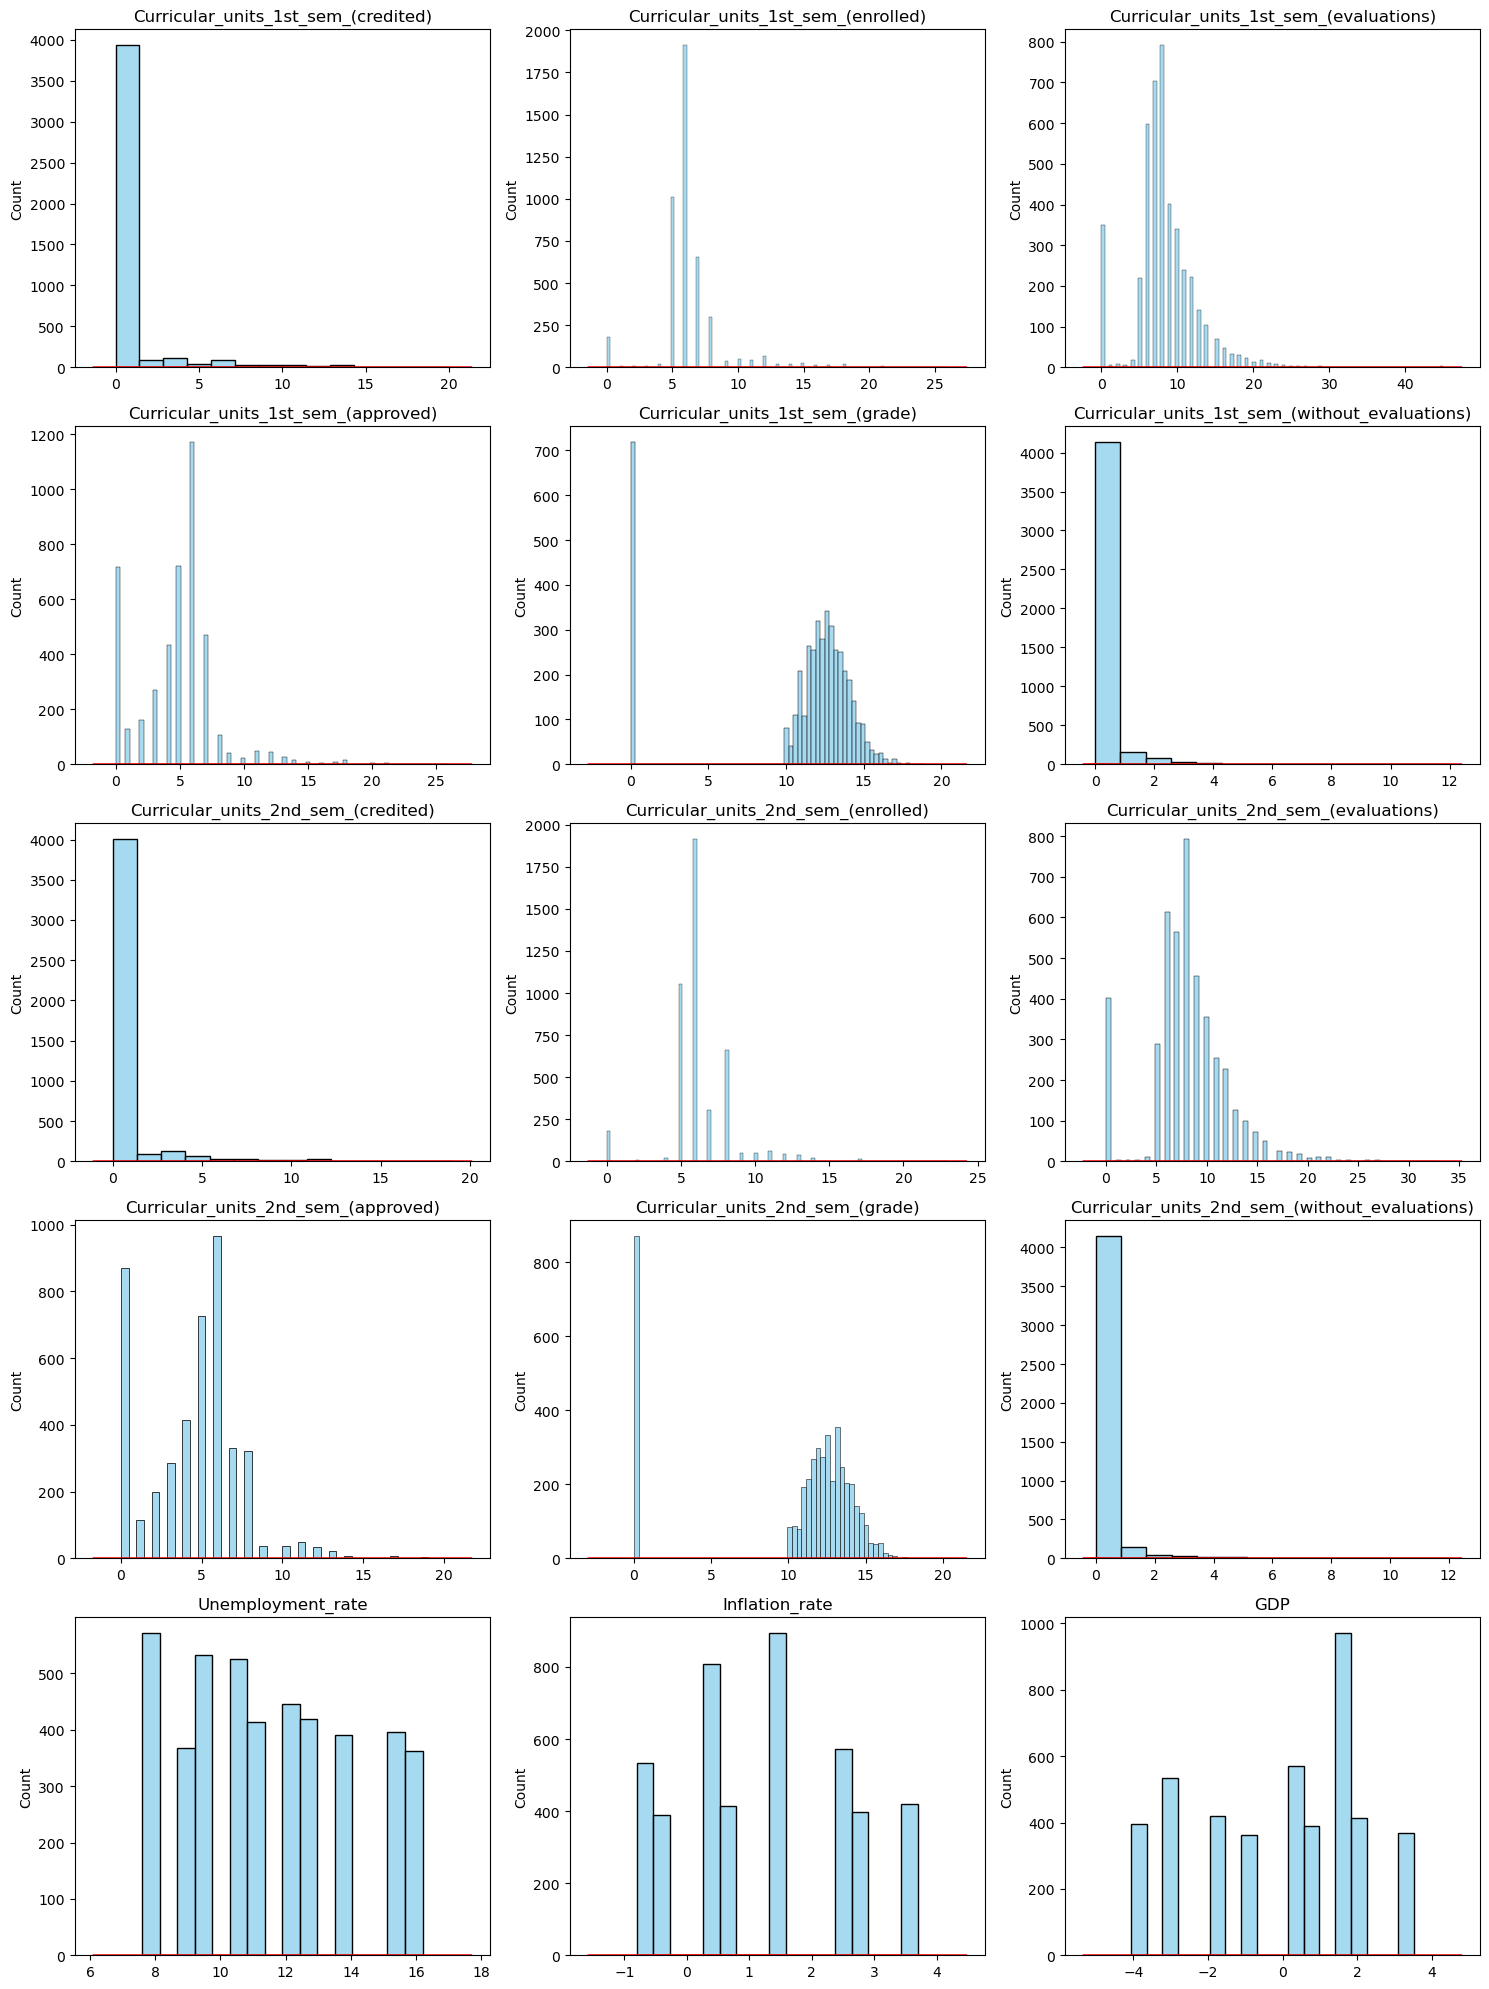

In [276]:
n_cols = 3
n_rows = (len(numeric_cols) - 1) // n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

# Flatten the axes array (in case it's 2D)
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, ax=axes[i], color='skyblue')
    sns.kdeplot(data=df, x=col, ax=axes[i], color='red')
    axes[i].set_title(col)
    axes[i].set_xlabel('') 

for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show();

### Some of the features in the student data set present a skewed distribution; it is one where the data values are not symmetrically distributed around the mean. Instead, they tend to trail off more sharply on one side than the other. This can occur due to various factors, including the presence of extreme values or outliers, but skewness can also arise from the inherent characteristics of the data itself.


### Looking for possible outliers in quantitative features

In [277]:

def detect_outliers(df, numeric_columns):
    """
    Identify outliers in specified numerical columns of a DataFrame using the IQR method.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    numeric_columns (list): A list of column names to check for outliers.

    Returns:
    str: A message indicating the number of columns with outliers and the percentage of outliers in each column,
         or a message stating that no columns have outliers.
    """
    
    outlier_dict = {}
    outlier_listing = {}
    counter = 0
    try:
        for column in numeric_columns:
            if column in df.columns:
                Q1 = df[column].quantile(0.25)
                Q3 = df[column].quantile(0.75)
                IQR = Q3 - Q1
            
                # Define the outlier bounds
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
            
                outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
                if len(outliers)> 0:
                # Store outliers in the dictionary
                    #outlier_listing[column]  = outliers.tolist()
                    outlier_dict[column] = round(len(outliers)/df.shape[0],2)#.tolist()
                    counter +=1
                else:
                    print(f"Info: {column} has no outliers.")
    
        #if counter == 0:
         #   return "No columns have outliers."
    
        return "There are {} columns with outliers. Each columns has the following % of outliers: {}".format(counter,outlier_dict)

    except Exception as e:
        return f"An error occurred: {str(e)}"


In [278]:
outlier_table = detect_outliers(df, numeric_cols)
print(outlier_table)

Info: Unemployment_rate has no outliers.
Info: Inflation_rate has no outliers.
Info: GDP has no outliers.
There are 12 columns with outliers. Each columns has the following % of outliers: {'Curricular_units_1st_sem_(credited)': 0.13, 'Curricular_units_1st_sem_(enrolled)': 0.1, 'Curricular_units_1st_sem_(evaluations)': 0.04, 'Curricular_units_1st_sem_(approved)': 0.04, 'Curricular_units_1st_sem_(grade)': 0.16, 'Curricular_units_1st_sem_(without_evaluations)': 0.07, 'Curricular_units_2nd_sem_(credited)': 0.12, 'Curricular_units_2nd_sem_(enrolled)': 0.08, 'Curricular_units_2nd_sem_(evaluations)': 0.02, 'Curricular_units_2nd_sem_(approved)': 0.01, 'Curricular_units_2nd_sem_(grade)': 0.2, 'Curricular_units_2nd_sem_(without_evaluations)': 0.06}


### Looking for possible outliers in categorical features


In [279]:
import pandas as pd

def detect_categorical_outliers(df, categorical_columns, threshold=0.05):
    """
    Identify rare categories in specified categorical columns of a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    categorical_columns (list): A list of column names to check for rare categories.
    threshold (float): The percentage threshold below which categories are considered outliers.

    Returns:
    dict: A dictionary with column names as keys and lists of rare categories as values,
          or a message stating that no rare categories were found.
    """
    outlier_dict = {}
    counter = 0
    
    try:
        for column in categorical_columns:
            if column in df.columns:

                category_counts = df[column].value_counts(normalize=True)
                
                rare_categories = category_counts[category_counts < threshold].index.tolist()
                
                if rare_categories:
                    outlier_dict[column] = rare_categories
                    counter+=1
                else:
                    print(f"Info: {column} has no outliers.")
        
        if not outlier_dict:
            return "No rare categories found in the specified columns."
        
        return "There is/are {} columns with outliers. Each columns has the following % outlier/s: {}".format(counter,outlier_dict)

    
    except Exception as e:
        return f"An error occurred: {str(e)}"



In [280]:
cat_var = df.select_dtypes(include='object').columns
outlier_table = detect_categorical_outliers(df, cat_var)
print(outlier_table)

Info: Daytime/evening_attendance has no outliers.
Info: Displaced has no outliers.
Info: Debtor has no outliers.
Info: Tuition_fees_up_to_date has no outliers.
Info: Gender has no outliers.
Info: Scholarship_holder has no outliers.
Info: Target has no outliers.
There is/are 13 columns with outliers. Each columns has the following % outlier/s: {'Marital_status': ['4', '5', '6', '3'], 'Application_mode': ['15', '4', '9', '13', '16', '7', '17', '6', '3', '5', '2', '18', '10', '11'], 'Application_order': ['5', '6', '9', '0'], 'Course': ['2', '3', '4', '16', '7', '8', '13', '1'], 'Previous_qualification': ['14', '12', '3', '9', '15', '16', '2', '6', '7', '4', '13', '17', '8', '11', '5', '10'], 'Nacionality': ['14', '12', '3', '9', '10', '16', '4', '18', '15', '8', '17', '11', '2', '19', '13', '5', '21', '20', '6', '7'], "Mother's_qualification": ['19', '2', '4', '10', '5', '25', '7', '24', '26', '27', '6', '28', '18', '20', '21', '9', '17', '8', '11', '12', '14', '16', '15', '29'], "Father'

### Since both quantitaive and qualitative features present outliers, it is essential to carefully assess, handle, and evaluate the impact of these outliers to ensure robust model performance.

In [281]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()


In [282]:
correlation_matrix

,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP
Curricular_units_1st_sem_(credited),1.000000,0.774344,0.542919,0.628394,0.122978,0.116262,0.944811,0.644826,0.427845,0.490478,0.132971,0.055256,0.009778,0.023348,-0.026513
Curricular_units_1st_sem_(enrolled),0.774344,1.000000,0.680220,0.769083,0.376996,0.129337,0.753747,0.942627,0.599567,0.673341,0.361959,0.069547,0.038404,0.036758,-0.026262
Curricular_units_1st_sem_(evaluations),0.542919,0.680220,1.000000,0.522396,0.418038,0.241800,0.522187,0.611842,0.778863,0.442265,0.355036,0.134296,0.061545,-0.006604,-0.099761
Curricular_units_1st_sem_(approved),0.628394,0.769083,0.522396,1.000000,0.696113,-0.013360,0.607661,0.733772,0.539934,0.904002,0.685560,-0.053983,0.051286,-0.007114,0.018459
Curricular_units_1st_sem_(grade),0.122978,0.376996,0.418038,0.696113,1.000000,-0.071660,0.113937,0.406167,0.487236,0.673335,0.837170,-0.066076,0.014821,-0.033904,0.054801
Curricular_units_1st_sem_(without_evaluations),0.116262,0.129337,0.241800,-0.013360,-0.071660,1.000000,0.117359,0.109924,0.144683,-0.013070,-0.061482,0.583261,-0.045144,-0.052534,-0.144673
Curricular_units_2nd_sem_(credited),0.944811,0.753747,0.522187,0.607661,0.113937,0.117359,1.000000,0.676258,0.430978,0.519081,0.129770,0.070148,0.010580,0.014490,-0.024491
Curricular_units_2nd_sem_(enrolled),0.644826,0.942627,0.611842,0.733772,0.406167,0.109924,0.676258,1.000000,0.604821,0.703258,0.395135,0.067697,0.064436,0.016844,-0.007592
Curricular_units_2nd_sem_(evaluations),0.427845,0.599567,0.778863,0.539934,0.487236,0.144683,0.430978,0.604821,1.000000,0.463535,0.453394,0.144877,0.045808,-0.012643,-0.004854
Curricular_units_2nd_sem_(approved),0.490478,0.673341,0.442265,0.904002,0.673335,-0.013070,0.519081,0.703258,0.463535,1.000000,0.760804,-0.061567,0.048805,-0.024566,0.022427


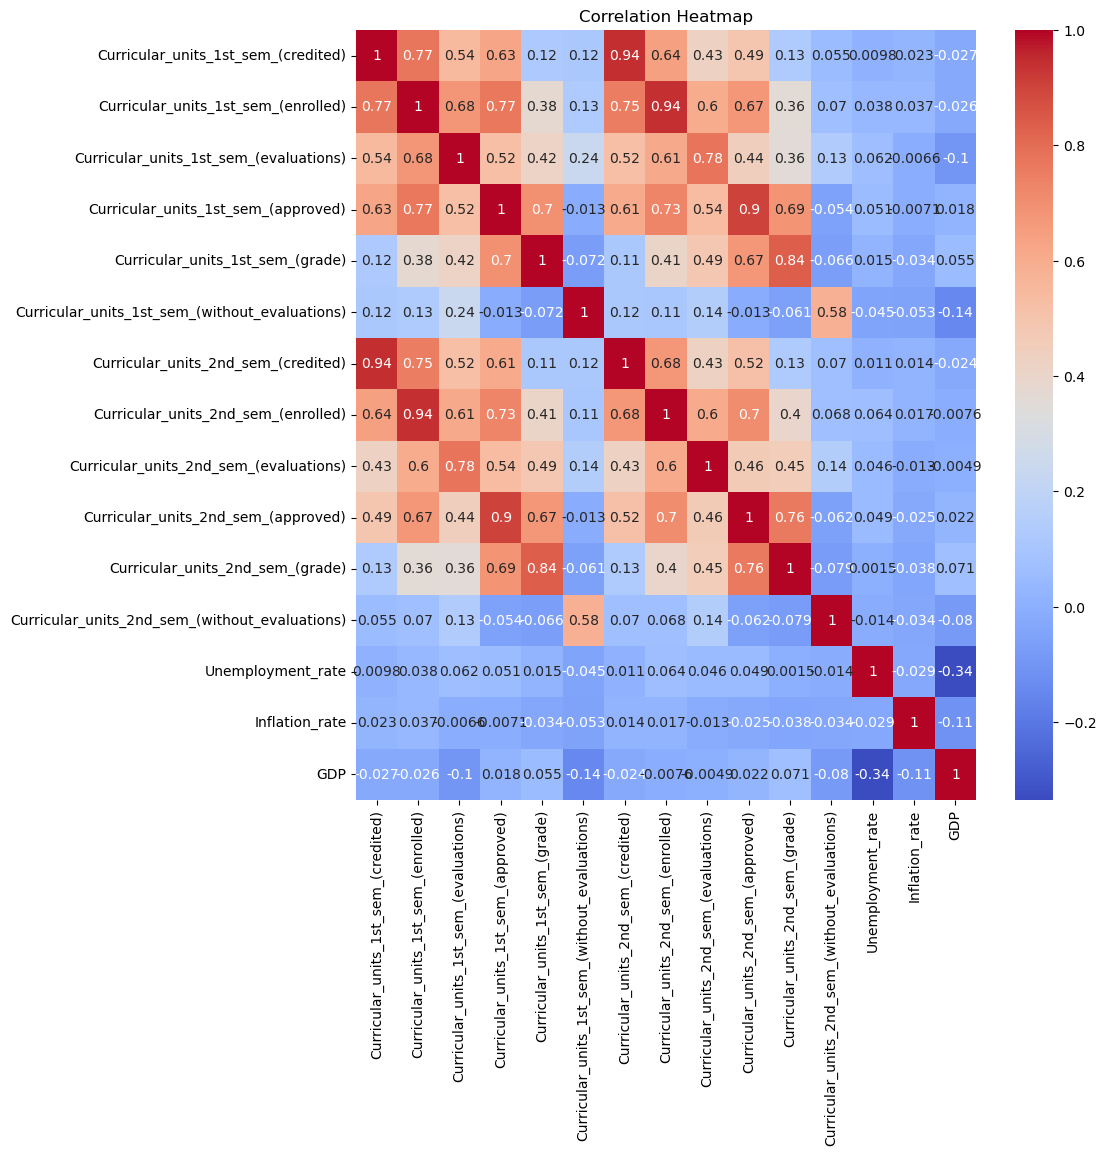

In [283]:
# Create the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Overall Correlation Strength:
### Some of the correlations in this matrix are strong which provide valuable insights into relationships between variables, but they also come with considerations, especially when building predictive models:


## 3.Data Preparation

### Creating lists to group features relevant to the questions indentified in the business understanding step.

In [284]:
# Grouping Variables

# Family Factors
family_factors = [
    'Marital_status',
    "Mother's_qualification",
    "Father's_qualification",
    "Mother's_occupation",
    "Father's_occupation",
    'Displaced'
]

# Demographic Factors
demographic_factors = [
    'Nacionality',
    'Gender',
    'Age_at_enrollment',
    'International'
]

# Application Factors
application_factors = [
    'Application_mode',
    'Application_order',
    'Course',
    'Daytime/evening_attendance',
    'Previous_qualification',
    'Scholarship_holder'
]

# Financial and Economic Factors
financial_economic_factors = [
    'Debtor',
    'Tuition_fees_up_to_date',
    'Unemployment_rate',
    'Inflation_rate',
    'GDP'
]

# Educational Engagement
educational_engagement = [
    'Curricular_units_1st_sem_(credited)',
    'Curricular_units_1st_sem_(enrolled)',
    'Curricular_units_1st_sem_(evaluations)',
    'Curricular_units_1st_sem_(approved)',
    'Curricular_units_1st_sem_(grade)',
    'Curricular_units_1st_sem_(without_evaluations)',
    'Curricular_units_2nd_sem_(credited)',
    'Curricular_units_2nd_sem_(enrolled)',
    'Curricular_units_2nd_sem_(evaluations)',
    'Curricular_units_2nd_sem_(approved)',
    'Curricular_units_2nd_sem_(grade)',
    'Curricular_units_2nd_sem_(without_evaluations)'
]

# Target Variable
target_variable = ['Target']


### Hot-Encoding Categorical Variables

In [294]:
cat_columns = df.select_dtypes(include='object').columns.drop('Target')  # Exclude Target
df_encoded = pd.get_dummies(df, 
                             columns=cat_columns, 
                             dummy_na=False, 
                             drop_first=True)

In [295]:
label_encoder = LabelEncoder()
df_encoded['Target_encoded'] = label_encoder.fit_transform(df['Target'])
df_encoded.drop(columns=['Target'], inplace=True)

In [296]:
df_encoded.shape

(4424, 287)

### After one-hot encoding, the final dataset has 287 columns and 4424 rows, which provides a ratio of approximately 15.4:1 .This ratio indicates that we have a reasonable number of columns relative to the rows, which is generally acceptable for many modeling tasks.

## 4.Data Modeling

In [297]:
df_encoded.head()

,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Marital_status_2,Marital_status_3,Marital_status_4,Marital_status_5,Marital_status_6,Application_mode_10,Application_mode_11,Application_mode_12,Application_mode_13,Application_mode_14,Application_mode_15,Application_mode_16,Application_mode_17,Application_mode_18,Application_mode_2,Application_mode_3,Application_mode_4,Application_mode_5,Application_mode_6,Application_mode_7,Application_mode_8,Application_mode_9,Application_order_1,Application_order_2,Application_order_3,Application_order_4,Application_order_5,Application_order_6,Application_order_9,Course_10,Course_11,Course_12,Course_13,Course_14,Course_15,Course_16,Course_17,Course_2,Course_3,Course_4,Course_5,Course_6,Course_7,Course_8,Course_9,Daytime/evening_attendance_1,Previous_qualification_10,Previous_qualification_11,Previous_qualification_12,Previous_qualification_13,Previous_qualification_14,Previous_qualification_15,Previous_qualification_16,Previous_qualification_17,Previous_qualification_2,Previous_qualification_3,Previous_qualification_4,Previous_qualification_5,Previous_qualification_6,Previous_qualification_7,Previous_qualification_8,Previous_qualification_9,Nacionality_10,Nacionality_11,Nacionality_12,Nacionality_13,Nacionality_14,Nacionality_15,Nacionality_16,Nacionality_17,Nacionality_18,Nacionality_19,Nacionality_2,Nacionality_20,Nacionality_21,Nacionality_3,Nacionality_4,Nacionality_5,Nacionality_6,Nacionality_7,Nacionality_8,Nacionality_9,Mother's_qualification_10,Mother's_qualification_11,Mother's_qualification_12,Mother's_qualification_13,Mother's_qualification_14,Mother's_qualification_15,Mother's_qualification_16,Mother's_qualification_17,Mother's_qualification_18,Mother's_qualification_19,Mother's_qualification_2,Mother's_qualification_20,Mother's_qualification_21,Mother's_qualification_22,Mother's_qualification_23,Mother's_qualification_24,Mother's_qualification_25,Mother's_qualification_26,Mother's_qualification_27,Mother's_qualification_28,Mother's_qualification_29,Mother's_qualification_3,Mother's_qualification_4,Mother's_qualification_5,Mother's_qualification_6,Mother's_qualification_7,Mother's_qualification_8,Mother's_qualification_9,Father's_qualification_10,Father's_qualification_11,Father's_qualification_12,Father's_qualification_13,Father's_qualification_14,Father's_qualification_15,Father's_qualification_16,Father's_qualification_17,Father's_qualification_18,Father's_qualification_19,Father's_qualification_2,Father's_qualification_20,Father's_qualification_21,Father's_qualification_22,Father's_qualification_23,Father's_qualification_24,Father's_qualification_25,Father's_qualification_26,Father's_qualification_27,Father's_qualification_28,Father's_qualification_29,Father's_qualification_3,Father's_qualification_30,Father's_qualification_31,Father's_qualification_32,Father's_qualification_33,Father's_qualification_34,Father's_qualification_4,Father's_qualification_5,Father's_qualification_6,Father's_qualification_7,Father's_qualification_8,Father's_qualification_9,Mother's_occupation_10,Mother's_occupation_11,Mother's_occupation_12,Mother's_occupation_13,Mother's_occupation_14,Mother's_occupation_15,Mother's_occupation_16,Mother's_occupation_17,Mother's_occupation_18,Mother's_occupation_19,Mother's_occupation_2,Mother's_occupation_20,Mother's_occupation_21,Mother's_occupation_22,Mother's_occupation_23,Mother's_occupation_24,Mother's_occupation_25,Mother's_occupation_26,Mother's_occupation_27,Mother's_occupation_28,Mother's_occupation_29,Mother's_occupatio

### Modeling the data to answer question 1 presented in the business understanding section.

In [298]:
selected_columns = [col for col in df_encoded.columns if any(col.startswith(factor + '_') for factor in family_factors)]

In [307]:
selected_columns

['Marital_status_2',
 'Marital_status_3',
 'Marital_status_4',
 'Marital_status_5',
 'Marital_status_6',
 "Mother's_qualification_10",
 "Mother's_qualification_11",
 "Mother's_qualification_12",
 "Mother's_qualification_13",
 "Mother's_qualification_14",
 "Mother's_qualification_15",
 "Mother's_qualification_16",
 "Mother's_qualification_17",
 "Mother's_qualification_18",
 "Mother's_qualification_19",
 "Mother's_qualification_2",
 "Mother's_qualification_20",
 "Mother's_qualification_21",
 "Mother's_qualification_22",
 "Mother's_qualification_23",
 "Mother's_qualification_24",
 "Mother's_qualification_25",
 "Mother's_qualification_26",
 "Mother's_qualification_27",
 "Mother's_qualification_28",
 "Mother's_qualification_29",
 "Mother's_qualification_3",
 "Mother's_qualification_4",
 "Mother's_qualification_5",
 "Mother's_qualification_6",
 "Mother's_qualification_7",
 "Mother's_qualification_8",
 "Mother's_qualification_9",
 "Father's_qualification_10",
 "Father's_qualification_11",
 "F

In [308]:
df_filtered = df_encoded[selected_columns+['Target_encoded']]

In [309]:
df_filtered.head()

,Marital_status_2,Marital_status_3,Marital_status_4,Marital_status_5,Marital_status_6,Mother's_qualification_10,Mother's_qualification_11,Mother's_qualification_12,Mother's_qualification_13,Mother's_qualification_14,Mother's_qualification_15,Mother's_qualification_16,Mother's_qualification_17,Mother's_qualification_18,Mother's_qualification_19,Mother's_qualification_2,Mother's_qualification_20,Mother's_qualification_21,Mother's_qualification_22,Mother's_qualification_23,Mother's_qualification_24,Mother's_qualification_25,Mother's_qualification_26,Mother's_qualification_27,Mother's_qualification_28,Mother's_qualification_29,Mother's_qualification_3,Mother's_qualification_4,Mother's_qualification_5,Mother's_qualification_6,Mother's_qualification_7,Mother's_qualification_8,Mother's_qualification_9,Father's_qualification_10,Father's_qualification_11,Father's_qualification_12,Father's_qualification_13,Father's_qualification_14,Father's_qualification_15,Father's_qualification_16,Father's_qualification_17,Father's_qualification_18,Father's_qualification_19,Father's_qualification_2,Father's_qualification_20,Father's_qualification_21,Father's_qualification_22,Father's_qualification_23,Father's_qualification_24,Father's_qualification_25,Father's_qualification_26,Father's_qualification_27,Father's_qualification_28,Father's_qualification_29,Father's_qualification_3,Father's_qualification_30,Father's_qualification_31,Father's_qualification_32,Father's_qualification_33,Father's_qualification_34,Father's_qualification_4,Father's_qualification_5,Father's_qualification_6,Father's_qualification_7,Father's_qualification_8,Father's_qualification_9,Mother's_occupation_10,Mother's_occupation_11,Mother's_occupation_12,Mother's_occupation_13,Mother's_occupation_14,Mother's_occupation_15,Mother's_occupation_16,Mother's_occupation_17,Mother's_occupation_18,Mother's_occupation_19,Mother's_occupation_2,Mother's_occupation_20,Mother's_occupation_21,Mother's_occupation_22,Mother's_occupation_23,Mother's_occupation_24,Mother's_occupation_25,Mother's_occupation_26,Mother's_occupation_27,Mother's_occupation_28,Mother's_occupation_29,Mother's_occupation_3,Mother's_occupation_30,Mother's_occupation_31,Mother's_occupation_32,Mother's_occupation_4,Mother's_occupation_5,Mother's_occupation_6,Mother's_occupation_7,Mother's_occupation_8,Mother's_occupation_9,Father's_occupation_10,Father's_occupation_11,Father's_occupation_12,Father's_occupation_13,Father's_occupation_14,Father's_occupation_15,Father's_occupation_16,Father's_occupation_17,Father's_occupation_18,Father's_occupation_19,Father's_occupation_2,Father's_occupation_20,Father's_occupation_21,Father's_occupation_22,Father's_occupation_23,Father's_occupation_24,Father's_occupation_25,Father's_occupation_26,Father's_occupation_27,Father's_occupation_28,Father's_occupation_29,Father's_occupation_3,Father's_occupation_30,Father's_occupation_31,Father's_occupation_32,Father's_occupation_33,Father's_occupation_34,Father's_occupation_35,Father's_occupation_36,Father's_occupation_37,Father's_occupation_38,Father's_occupation_39,Father's_occupation_4,Father's_occupation_40,Father's_occupation_41,Father's_occupation_42,Father's_occupation_43,Father's_occupation_44,Father's_occupation_45,Father's_occupation_46,Father's_occupation_5,Father's_occupation_6,Father's_occupation_7,Father's_occupation_8,Father's_occupation_9,Displaced_1,Target_encoded
0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True

In [310]:
X = df_filtered.drop('Target_encoded', axis=1)
y = df_filtered['Target_encoded']

### Split the Data

In [311]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Fit a Random Forest Model

In [324]:

model = RandomForestClassifier(class_weight='balanced', random_state=42)

model.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', random_state=42)

### Evaluate Feature importance

                       Feature  Importance
142                Displaced_1    0.059526
8    Mother's_qualification_13    0.051618
37   Father's_qualification_14    0.048722
51   Father's_qualification_27    0.039418
66      Mother's_occupation_10    0.036848
19   Mother's_qualification_23    0.035761
92       Mother's_occupation_5    0.035088
18   Mother's_qualification_22    0.033045
52   Father's_qualification_28    0.030988
138      Father's_occupation_6    0.030168
26    Mother's_qualification_3    0.028868
0             Marital_status_2    0.028618
93       Mother's_occupation_6    0.028240
97      Father's_occupation_10    0.027668
140      Father's_occupation_8    0.024460
54    Father's_qualification_3    0.023675
141      Father's_occupation_9    0.023486
137      Father's_occupation_5    0.023467
91       Mother's_occupation_4    0.022687
129      Father's_occupation_4    0.022081
98      Father's_occupation_11    0.021847
95       Mother's_occupation_8    0.020572
139      Fa

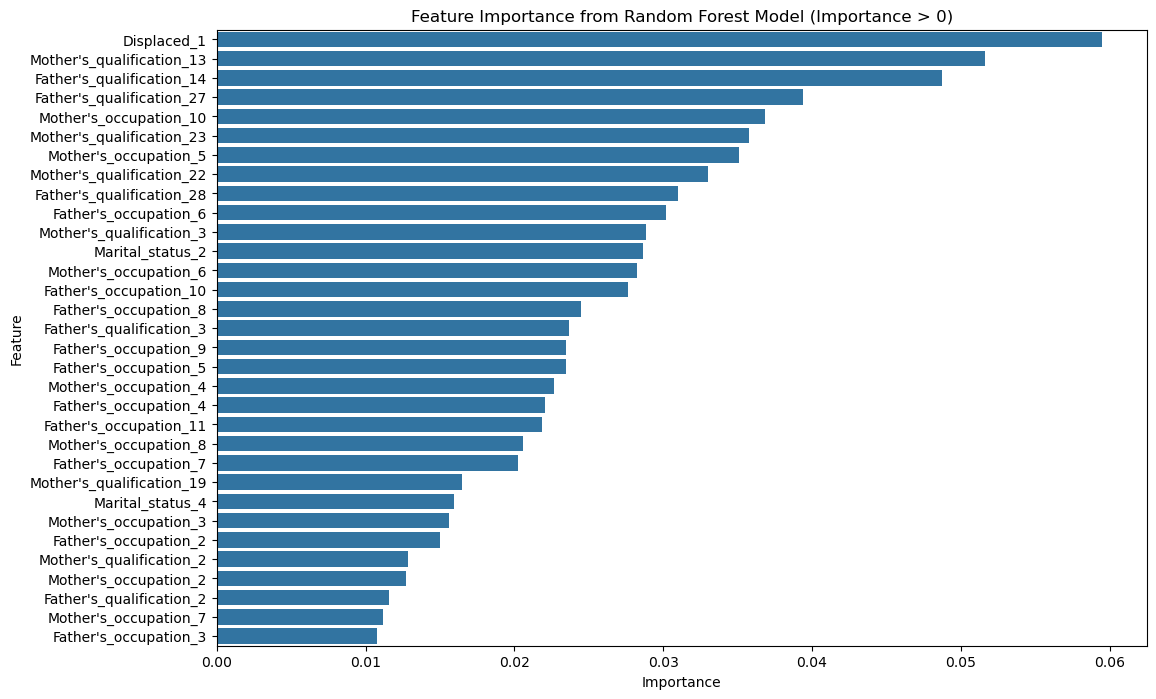

In [325]:
# Get feature importances
feature_importance = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
# Filter features with importance greater than 0
importance_df = importance_df[importance_df['Importance'] > 0.01]

# Print the filtered DataFrame
print(importance_df)

# Optionally visualize the filtered feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest Model (Importance > 0)')
plt.show()


In [326]:
y_pred = model.predict(X_test)


In [327]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)


Accuracy: 0.39
Confusion Matrix:
[[113  39 132]
 [ 56  24  79]
 [151  79 212]]
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.40      0.37       284
           1       0.17      0.15      0.16       159
           2       0.50      0.48      0.49       442

    accuracy                           0.39       885
   macro avg       0.34      0.34      0.34       885
weighted avg       0.39      0.39      0.39       885



In [323]:
df_filtered['Target_encoded'].value_counts(normalize=True)

Target_encoded
2    0.499322
0    0.321203
1    0.179476
Name: proportion, dtype: float64

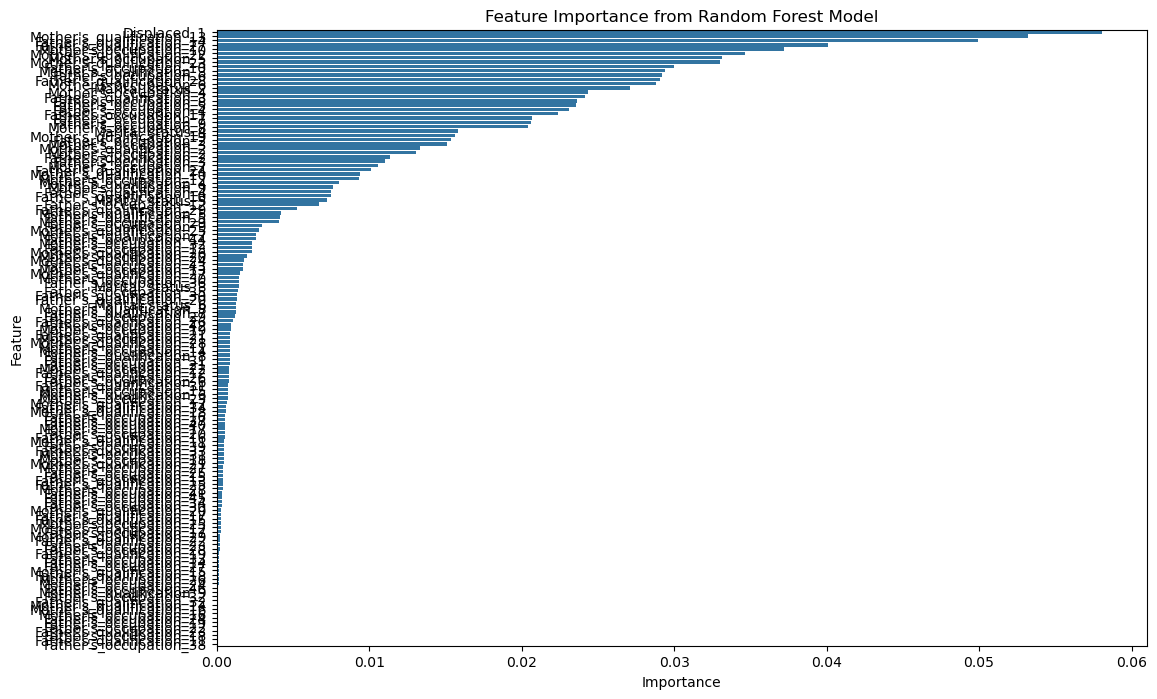

In [315]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance from Random Forest Model')
plt.show()


In [314]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 97  21 166]
 [ 51   9  99]
 [123  36 283]]

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.34      0.35       284
           1       0.14      0.06      0.08       159
           2       0.52      0.64      0.57       442

    accuracy                           0.44       885
   macro avg       0.34      0.35      0.33       885
weighted avg       0.40      0.44      0.41       885



### Train the Random Forest Model

In [165]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate classification report
report = classification_report(y_test, y_pred, target_names=['Not Dropped Out', 'Dropped Out'])
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.89
                 precision    recall  f1-score   support

Not Dropped Out       0.90      0.98      0.94      3602
    Dropped Out       0.09      0.02      0.03       398

       accuracy                           0.89      4000
      macro avg       0.49      0.50      0.48      4000
   weighted avg       0.82      0.89      0.85      4000

Confusion Matrix:
[[3539   63]
 [ 392    6]]


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      5390
           1       0.10      0.22      0.14       610

    accuracy                           0.73      6000
   macro avg       0.50      0.50      0.49      6000
weighted avg       0.82      0.73      0.77      6000

Confusion Matrix:
[[4217 1173]
 [ 476  134]]
Precision-Recall AUC: 0.1045


<Figure size 1000x600 with 0 Axes>

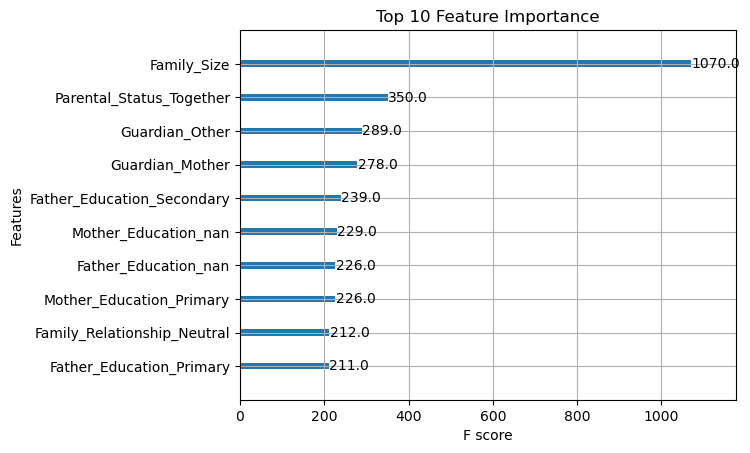

In [93]:
# Required imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from xgboost import XGBClassifier

# Split dataset into features (X) and target (y)
X = df_filtered.drop('Dropped_Out', axis=1)
y = df_filtered['Dropped_Out']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Handle class imbalance by setting scale_pos_weight
# Calculate the ratio of majority class to minority class
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Create an XGBoost Classifier with scale_pos_weight for imbalance
xgb_model = XGBClassifier(scale_pos_weight=pos_weight, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Print classification report to see precision, recall, and f1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Precision-Recall Curve and AUC
y_probs = xgb_model.predict_proba(X_test)[:, 1]  # Probability of positive class
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
print(f'Precision-Recall AUC: {pr_auc:.4f}')

# Feature importance using built-in XGBoost feature importance method
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10)
plt.title('Top 10 Feature Importance')
plt.show()


In [82]:
from sklearn.ensemble import RandomForestClassifier

#model = RandomForestClassifier(random_state=42)
model = RandomForestClassifier(random_state=42, class_weight='balanced')

model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

### Evaluate Feature Importance

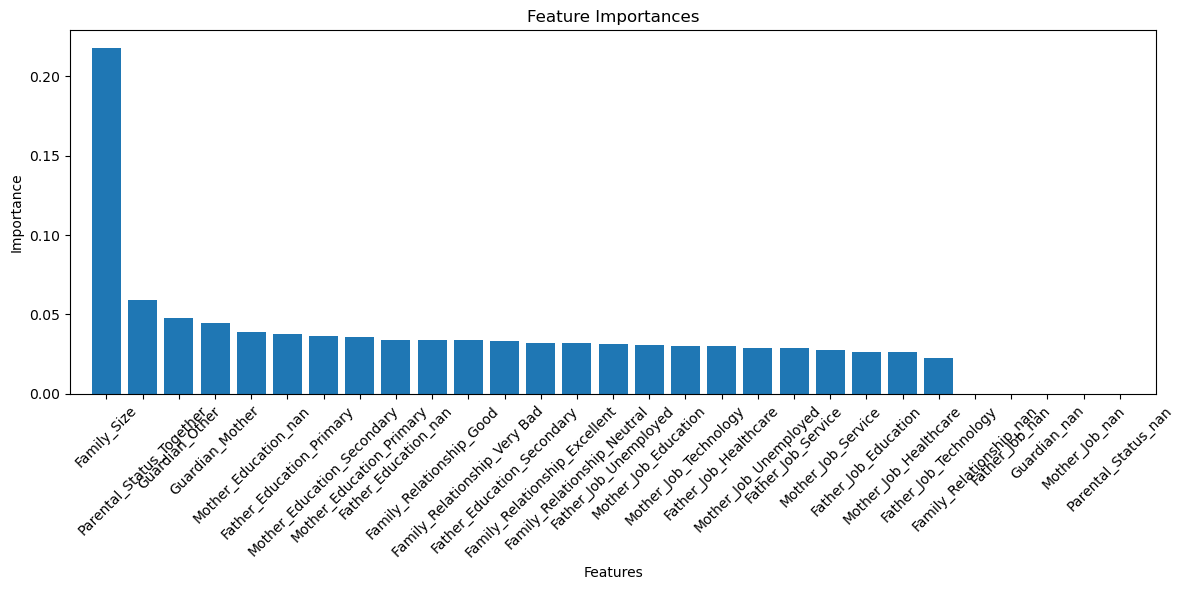

In [83]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Create a larger figure
plt.figure(figsize=(12, 6))  # Adjust the figsize as needed

# Plot the feature importances
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)  # Rotate x-axis labels by 45 degrees
plt.xlim([-1, X.shape[1]])
plt.xlabel("Features")  # Optional: Add x-axis label
plt.ylabel("Importance")  # Optional: Add y-axis label
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


In [84]:
# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display the DataFrame
print(feature_importance_df)

                          Feature  Importance
0                     Family_Size    0.217900
1        Parental_Status_Together    0.058857
2                  Guardian_Other    0.047773
3                 Guardian_Mother    0.044765
4            Mother_Education_nan    0.038987
5        Father_Education_Primary    0.037573
6      Mother_Education_Secondary    0.036202
7        Mother_Education_Primary    0.035782
8            Father_Education_nan    0.034071
9        Family_Relationship_Good    0.033659
10   Family_Relationship_Very Bad    0.033621
11     Father_Education_Secondary    0.033352
12  Family_Relationship_Excellent    0.032220
13    Family_Relationship_Neutral    0.031922
14          Father_Job_Unemployed    0.031188
15           Mother_Job_Education    0.031016
16          Mother_Job_Technology    0.030377
17          Father_Job_Healthcare    0.029878
18          Mother_Job_Unemployed    0.029108
19             Father_Job_Service    0.028745
20             Mother_Job_Service 

In [85]:
### Making predicitons

In [86]:
# Make predictions
y_pred = model.predict(X_test)


In [88]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Model Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      3602
           1       0.09      0.02      0.03       398

    accuracy                           0.89      4000
   macro avg       0.49      0.50      0.48      4000
weighted avg       0.82      0.89      0.85      4000



In [109]:
# Step 1: One-Hot Encoding categorical variables
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_encoded = pd.get_dummies(df.drop(columns=['Dropped_Out']), dummy_na=True,drop_first=True)  # Drop target and encode
y = df['Dropped_Out']

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 3: Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

#rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Step 5: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8975
Classification Report:
               precision    recall  f1-score   support

          No       0.90      1.00      0.95      3590
         Yes       0.00      0.00      0.00       410

    accuracy                           0.90      4000
   macro avg       0.45      0.50      0.47      4000
weighted avg       0.81      0.90      0.85      4000

Confusion Matrix:
 [[3590    0]
 [ 410    0]]


In [108]:
df['Dropped_Out'].value_counts(normalize=True)

Dropped_Out
No     0.90055
Yes    0.09945
Name: proportion, dtype: float64

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

# Splitting your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Dropped_Out'], test_size=0.2, random_state=42)

# Random Forest with class_weight='balanced'
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_classifier.predict(X_test)
y_prob_rf = rf_classifier.predict_proba(X_test)[:, 1]

# Model evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("Random Forest AUC-ROC:", roc_auc_score(y_test, y_prob_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

          No       0.90      0.98      0.94      3590
         Yes       0.10      0.01      0.03       410

    accuracy                           0.89      4000
   macro avg       0.50      0.50      0.48      4000
weighted avg       0.82      0.89      0.85      4000

Random Forest Confusion Matrix:
[[3536   54]
 [ 404    6]]
Random Forest AUC-ROC: 0.505921258237652


In [117]:
#df['Dropped_Out'] = df['Dropped_Out'].map({'Yes': 1, 'No': 0})
y_train = y_train.map({'Yes':1,'No':0})
y_test  = y_test.map({'Yes':1,'No':0})

In [118]:
from imblearn.over_sampling import SMOTE

# Oversample with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# XGBoost with oversampled data
xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_resampled, y_resampled)

# Predictions
y_pred_xgb_smote = xgb_classifier.predict(X_test)
y_prob_xgb_smote = xgb_classifier.predict_proba(X_test)[:, 1]

# Model evaluation
print("XGBoost (with SMOTE) Classification Report:")
print(classification_report(y_test, y_pred_xgb_smote))

print("XGBoost (with SMOTE) Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_smote))

print("XGBoost (with SMOTE) AUC-ROC:", roc_auc_score(y_test, y_prob_xgb_smote))


ValueError: Input y contains NaN.

In [103]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Assuming 'dropout' is your target variable and `df` is your DataFrame
X = df_filtered.drop('Dropped_Out', axis=1)
y = df_filtered['Dropped_Out']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Add constant for logistic regression
X_train_const = sm.add_constant(X_train)

# Fit the model
model = sm.Logit(y_train, X_train_const).fit()

# Summary of the logistic regression model
print(model.summary())


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).